# Clasificación de Posiciones en Voleibol mediante Random Forest

##  Objetivo del análisis

En este análisis se aplica un enfoque de aprendizaje automático supervisado para predecir la **posición de un jugador de voleibol** en función de sus estadísticas individuales de rendimiento. El objetivo es construir un modelo que, a partir de variables como ataques, bloqueos, saques, entre otros, sea capaz de identificar si un jugador desempeña el rol de **opuesto (OP)**, **receptor punta (OH)**, u otra posición.

Para ello antes voy a explicar que algoritmo vamos a usar.

### ¿Qué es Random Forest?

**Random Forest** es un algoritmo de aprendizaje automático muy utilizado para tareas de clasificación y regresión. Su funcionamiento se basa en construir múltiples **árboles de decisión**, y combinar sus resultados para hacer una predicción más precisa y robusta.

Cada árbol hace una predicción y, al final, se toma la decisión por mayoría (en clasificación) o haciendo una media (en regresión). Esta estrategia ayuda a evitar errores que podría cometer un único árbol, mejorando la **precisión** del modelo y reduciendo el riesgo de **sobreajuste**.

### Aplicación en el análisis deportivo

En el contexto deportivo, Random Forest es especialmente útil cuando se quiere:

- **Clasificar jugadores** según su posición o estilo de juego, a partir de estadísticas individuales.
- **Predecir el rendimiento** de un jugador basándose en datos históricos.
- **Identificar las variables más influyentes**, como qué habilidades técnicas son más determinantes para ciertas posiciones.

Antes de comenzar se importan las librerías.

- **`pandas`**: para leer y manipular datos en forma de tablas (DataFrames), muy útil en análisis deportivos donde se trabaja con estadísticas de jugadores o equipos.
- **`numpy`**: para operaciones matemáticas eficientes, aunque no siempre se usa directamente, muchas librerías lo utilizan internamente.
- **`matplotlib` y `seaborn`**: para crear gráficos que ayuden a visualizar patrones en los datos, por ejemplo, comparar el rendimiento de distintas posiciones.
- **`sklearn` (scikit-learn)**: es una de las librerías más utilizadas en machine learning. Aquí encontraremos herramientas para dividir los datos, crear el modelo Random Forest y evaluar su rendimiento.

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



## Carga de Datos

Ahora cargamos el dataset y vemos su información usando metodos de pandas

In [5]:
data_frame = pd.read_csv('VNL2023.csv')
data_frame.head()

,Player,Country,Age,Attack,Block,Serve,Set,Dig,Receive,Position
0,Ichikawa Yuki,Japan,28,15.80,1.13,1.40,0.07,4.80,5.60,OH
1,Romano Yuri,Italy,26,12.33,1.07,1.47,0.00,3.87,0.00,OP
2,Abdel-Aziz Nimir,Nederland,31,15.33,0.67,2.08,0.00,3.17,0.25,OP
3,Herrera Jaime Jesus,Cuba,28,15.00,0.92,1.75,0.00,3.33,0.17,OP
4,Takahashi Ran,Japan,22,11.53,0.67,1.00,0.07,6.40,5.07,OH


Tras cargar y ver el dataset se comienza la exploración y limpieza de datos, pueden haber valores nulos, que no interesen y observar la distribución.


Para la exploración de datos tenemos varias opciones 
Los metodos .isnull().sum() nos devuelven la suma de los valores  nulos, al no aparecer nada, no hay valores nulos
El meotdo describe() nos devuelve datos muy interesantes para distintos objetivos, como la media(mean) valores mínimos y máximos o icluso el 25% y 75%

In [6]:
data_frame.isnull().sum()
data_frame.describe()

,Age,Attack,Block,Serve,Set,Dig,Receive
count,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000
mean,27.809160,5.642672,0.845573,0.535802,2.192595,3.428397,1.684198
std,4.186268,4.256229,0.700896,0.454346,6.031587,2.077823,1.989939
min,19.000000,0.000000,0.000000,0.000000,0.000000,0.530000,0.000000
25%,25.000000,2.800000,0.370000,0.240000,0.000000,1.920000,0.000000
50%,27.000000,5.170000,0.690000,0.420000,0.000000,3.000000,0.330000
75%,30.000000,8.600000,1.140000,0.760000,0.000000,4.510000,3.385000
max,41.000000,15.800000,4.080000,2.080000,26.890000,11.440000,6.690000


Ya que nuestro objetivo es predecir la posición del jugador, nos interesa saber cuántos ejemplos tenemos de cada tipo. Esto nos ayuda a detectar si el dataset está desbalanceado (es decir, si hay muchas más muestras de una posición que de otra).

In [7]:
data_frame['Position'].value_counts()


Position
OH    42
MB    32
OP    25
S     16
L     16
Name: count, dtype: int64


### Distribución de posiciones

Analizamos cuántos jugadores hay en cada posición:

- **OH (Receptor punta)**: 42 jugadores  
- **MB (Central)**: 32 jugadores  
- **OP (Opuesto)**: 25 jugadores  
- **S (Colocador)**: 16 jugadores  
- **L (Líbero)**: 16 jugadores

Esta distribución nos indica que hay cierta variación en el número de muestras por clase. Aunque no es extremadamente desbalanceado, debemos tenerlo en cuenta a la hora de evaluar el rendimiento del modelo.

---

### Estadísticas descriptivas

A continuación se muestran algunas estadísticas básicas de las variables numéricas:

| Variable | Media | Desv. típica | Mínimo | Máximo |
|----------|-------|--------------|--------|--------|
| Edad     | 27.8  | 4.19         | 19     | 41     |
| Ataque   | 5.64  | 4.26         | 0.00   | 15.80  |
| Bloqueo  | 0.85  | 0.70         | 0.00   | 4.08   |
| Saque    | 0.54  | 0.45         | 0.00   | 2.08   |
| Colocación | 2.19 | 6.03        | 0.00   | 26.89  |
| Defensa  | 3.43  | 2.08         | 0.53   | 11.44  |
| Recepción| 1.68  | 1.99         | 0.00   | 6.69   |

Estas estadísticas nos permiten detectar:

- Variables como *Attack* o *Block* con mayor varianza, lo que sugiere que podrían ser útiles para diferenciar entre posiciones.
- Columnas como *Set*, *Dig* y *Receive* que podrían ser especialmente relevantes para roles específicos como colocador (S) o líbero (L).



## Selección de variables y división del conjunto de datos

En esta sección preparamos los datos para el modelo. Esto incluye seleccionar las variables que vamos a usar para predecir la posición de los jugadores, y dividir el conjunto de datos en entrenamiento y prueba.

---

### 1. Selección de variables predictoras

Elegimos las columnas que contienen estadísticas numéricas relacionadas con el rendimiento del jugador en distintas habilidades. Estas variables serán las que el modelo utilizará para hacer sus predicciones.

- **`Age`**: Edad del jugador.
- **`Attack`**: Puntos de ataque.
- **`Block`**: Bloqueos realizados.
- **`Serve`**: Saques.
- **`Set`**: Puntos de colocación.
- **`Dig`**: Defensas realizadas.
- **`Receive`**: Recepciones.

Estas estadísticas permiten que el modelo entienda qué tan bien se desempeña un jugador en distintas áreas.

---

### 2. División en entrenamiento y prueba

Dividimos los datos en dos partes:

- **80% para entrenamiento**: el modelo aprende con estos datos.
- **20% para prueba**: se evalúa el rendimiento del modelo con datos no vistos.

Esta división ayuda a garantizar que el modelo generalice bien a nuevos datos.



In [8]:

# Variables predictoras (X)
X = data_frame[['Age', 'Attack', 'Block', 'Serve', 'Set', 'Dig', 'Receive']]

# Variable objetivo (y): la posición del jugador
y = data_frame['Position']

# División en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Entrenamiento del modelo Random Forest

Ahora que tenemos nuestros datos listos, podemos construir y entrenar el modelo **Random Forest**.

### 1. Entrenamiento del modelo

Usamos el conjunto de entrenamiento para entrenar el modelo. Este modelo aprenderá a predecir la posición del jugador a partir de las estadísticas de rendimiento que hemos seleccionado.



In [9]:
# Inicializamos el clasificador Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenamos el modelo con los datos de entrenamiento
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)


### 2. Evaluación del modelo

Una vez entrenado el modelo, podemos evaluar su rendimiento usando los datos de prueba. Esto nos permite conocer qué tan bien el modelo puede predecir la posición de los jugadores cuando se enfrenta a nuevos datos, que no ha visto durante el entrenamiento.

Existen varias métricas para evaluar el rendimiento de un modelo de clasificación. En este caso, vamos a calcular la **precisión** del modelo, que es la proporción de predicciones correctas sobre el total de predicciones realizadas. También podemos observar otras métricas como **recall**, **F1-score**, y **matriz de confusión**.





In [10]:
# Predicción con los datos de prueba
y_pred = random_forest.predict(X_test)

# Cálculo de la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión: {accuracy:.2f}')

# Reporte de clasificación con otras métricas
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

Precisión: 0.89
Reporte de clasificación:
              precision    recall  f1-score   support

           L       1.00      1.00      1.00         3
          MB       0.70      1.00      0.82         7
          OH       1.00      0.91      0.95        11
          OP       1.00      0.50      0.67         4
           S       1.00      1.00      1.00         2

    accuracy                           0.89        27
   macro avg       0.94      0.88      0.89        27
weighted avg       0.92      0.89      0.89        27

Matriz de confusión:
[[ 3  0  0  0  0]
 [ 0  7  0  0  0]
 [ 0  1 10  0  0]
 [ 0  2  0  2  0]
 [ 0  0  0  0  2]]


## Resultados del modelo

El modelo Random Forest ha sido evaluado y hemos obtenido métricas. Estos resultados nos proporcionan una visión clara de la capacidad del modelo para predecir la posición de los jugadores en función de sus características.

---

### 1. Precisión

La **precisión** general del modelo es **0.89**, lo que significa que el 89% de las predicciones del modelo fueron correctas. Este es un buen indicador de que el modelo está clasificando correctamente la mayoría de las posiciones.

---

### 2. Reporte de clasificación

El reporte de clasificación proporciona información más detallada sobre cómo el modelo ha clasificado cada una de las posiciones (L, MB, OH, OP, S).

| **Posición** | **Precisión** | **Recall** | **F1-score** | **Support** |
|--------------|---------------|------------|--------------|-------------|
| **L**        | 1.00          | 1.00       | 1.00         | 3           |
| **MB**       | 0.70          | 1.00       | 0.82         | 7           |
| **OH**       | 1.00          | 0.91       | 0.95         | 11          |
| **OP**       | 1.00          | 0.50       | 0.67         | 4           |
| **S**        | 1.00          | 1.00       | 1.00         | 2           |

- **Precisión**: Mide qué porcentaje de las predicciones positivas fueron correctas.
- **Recall**: Mide qué porcentaje de los casos reales de esa clase fueron identificados correctamente por el modelo.
- **F1-score**: Es una medida combinada de la precisión y el recall.

---

### 3. Interpretación de los resultados

- Las posiciones **L** (líbero), **S** (colocador) y **OH** (receptor punta) tienen una precisión bastante alta, indicando que el modelo puede clasificar correctamente a los jugadores en estas posiciones.
- Para la posición **MB** (central), la precisión es más baja (0.70), pero el recall es perfecto (1.00), lo que indica que el modelo es muy bueno para identificar a los jugadores que realmente ocupan esta posición, aunque algunas predicciones pueden ser incorrectas.
- Para la posición **OP** (opuesto), la precisión es alta (1.00), pero el recall es relativamente bajo (0.50), lo que significa que el modelo no identifica todos los jugadores que deberían ser clasificados en esta posición.

---

### 4. Matriz de confusión

La matriz de confusión nos muestra cómo el modelo ha clasificado cada clase en relación con las clases reales:
  
 [ 3 0 0 0 0]   
 [ 0 7 0 0 0]   
 [ 0 1 10 0 0]   
 [ 0 2 0 2 0]   
 [ 0 0 0 0 2]   
  

La diagonal principal (de arriba a la izquierda a abajo a la derecha) muestra las clasificaciones correctas para cada clase. Por ejemplo, el modelo predijo correctamente los 3 jugadores de la posición **L**, los 7 de la posición **MB**, y así sucesivamente.
- Los valores fuera de la diagonal representan las predicciones incorrectas. Por ejemplo, hubo 1 jugador clasificado incorrectamente de **OH** como **MB**.






## Visualización e Interpretación

Tras los resultados del modelo, voy primero a explicar cómo he hecho la visualización y después veremos la interpretación y conclusión de los resultados.

### 1. Visualización

Para la visualización, vamos a usar dos tipos de gráficos para ver los resultados: uno de barras y otro radar.

- En el gráfico de barras podemos apreciar el valor promedio por estadística y, por colores, vemos las posiciones con más valores promedio en esa estadística.
- En el gráfico radar he separado distintos gráficos por posiciones para ver las estadísticas en cada posición.

### 2. Interpretación

Empezando por el gráfico de barras, vamos a explorar cuáles son las posiciones con más valores en cada estadística.

- **Ataque:** En esta característica, las posiciones son, en orden descendente: Punta, Opuesto, Bloqueador Central y, con un valor mucho menor, Colocador. Tiene sentido, ya que son las tres primeras posiciones encargadas del ataque, y el colocador suele dar el pase.
- **Bloqueo:** En esta característica, las posiciones son, en orden descendente: con una gran diferencia respecto a las demás, Bloqueador, luego tenemos a Opuesto, Punta y Colocador. Esto se debe a la función, como dice el nombre, del bloqueador central.
- **Saque:** El saque tiene todos una media muy parecida; la posición no suele influir en el saque.
- **Colocación:** En esta característica vemos una diferencia abismal, ya que en la gran mayoría de los casos, los colocadores dan el segundo toque, el pase al rematador o set. A destacar que el backup del colocador suele ser el opuesto.
- **Dig:** En este dataset, "dig" se refiere a "salvadas" o recepciones a remates o bolas sueltas. En este caso, vemos también una gran diferencia, ya que el líbero es la posición más defensiva. A destacar que el Bloqueador Central es el que menos tiene, ya que al rotar nunca está en la parte trasera, solo tras sacar.
- **Recepción:** Esta es la recepción tras saques, donde vemos también una diferencia en el líbero, el encargado de la defensa, y después el Punta, que es el backup del líbero.

Ahora con el gráfico de radar, vamos a explorar las caracteristicas más usadas por cada posición de fomra individual

Analizando cada gráfico de radar, podemos identificar las características distintivas de cada posición en términos de sus valores promedio en las diferentes estadísticas:

- **Líbero (L):** El gráfico del líbero muestra un área sombreada significativamente extendida en **Dig** y **Recepción**, lo que confirma su rol principal en la defensa del campo y la recepción de saques. Presenta valores bajos en Ataque, Bloqueo y Colocación, lo esperado dado su función especializada. El valor en Saque parece moderado.

- **Bloqueador Central (MB):** Este gráfico destaca un valor muy alto en **Bloqueo**, lo que es la característica principal de esta posición. También muestra un valor considerable en **Ataque**, principalmente en remates cortos y rápidos. Los valores en Recepción, Dig y Colocación son bajos, lo que también concuerda con su rol enfocado en la red. El valor en Saque parece bajo.

- **Receptor/Atacante (OH - Outside Hitter):** El receptor/atacante presenta valores altos en **Ataque** y **Recepción**, reflejando su doble función tanto en la ofensiva como en la defensa de primera línea. También muestra valores notables en **Bloqueo** y **Dig**, siendo jugadores versátiles en ambas zonas del campo. El valor en Colocación es bajo, y el valor en Saque parece moderado.

- **Opuesto (OP - Opposite Hitter):** El opuesto se caracteriza por un valor muy alto en **Ataque**, siendo uno de los principales atacantes del equipo. También muestra un valor considerable en **Bloqueo**, contribuyendo en la defensa en la red. Los valores en Recepción y Dig son más bajos en comparación con el líbero y el receptor/atacante, pero aún presentes. El valor en Colocación es bajo, aunque a veces pueden realizar colocaciones de emergencia. El valor en Saque parece moderado.

- **Colocador (S - Setter):** El gráfico del colocador muestra un valor extremadamente alto en **Colocación (Set)**, lo que define su rol principal en la distribución del juego ofensivo. Presenta valores bajos en Ataque, Bloqueo, Recepción y Dig, ya que su enfoque principal es el segundo toque. El valor en Saque parece bajo.

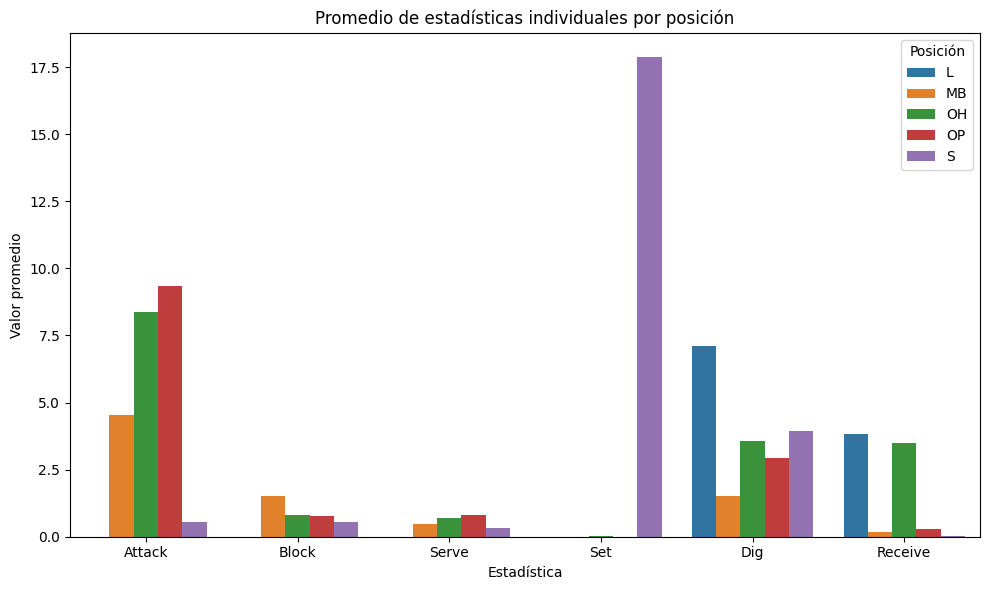

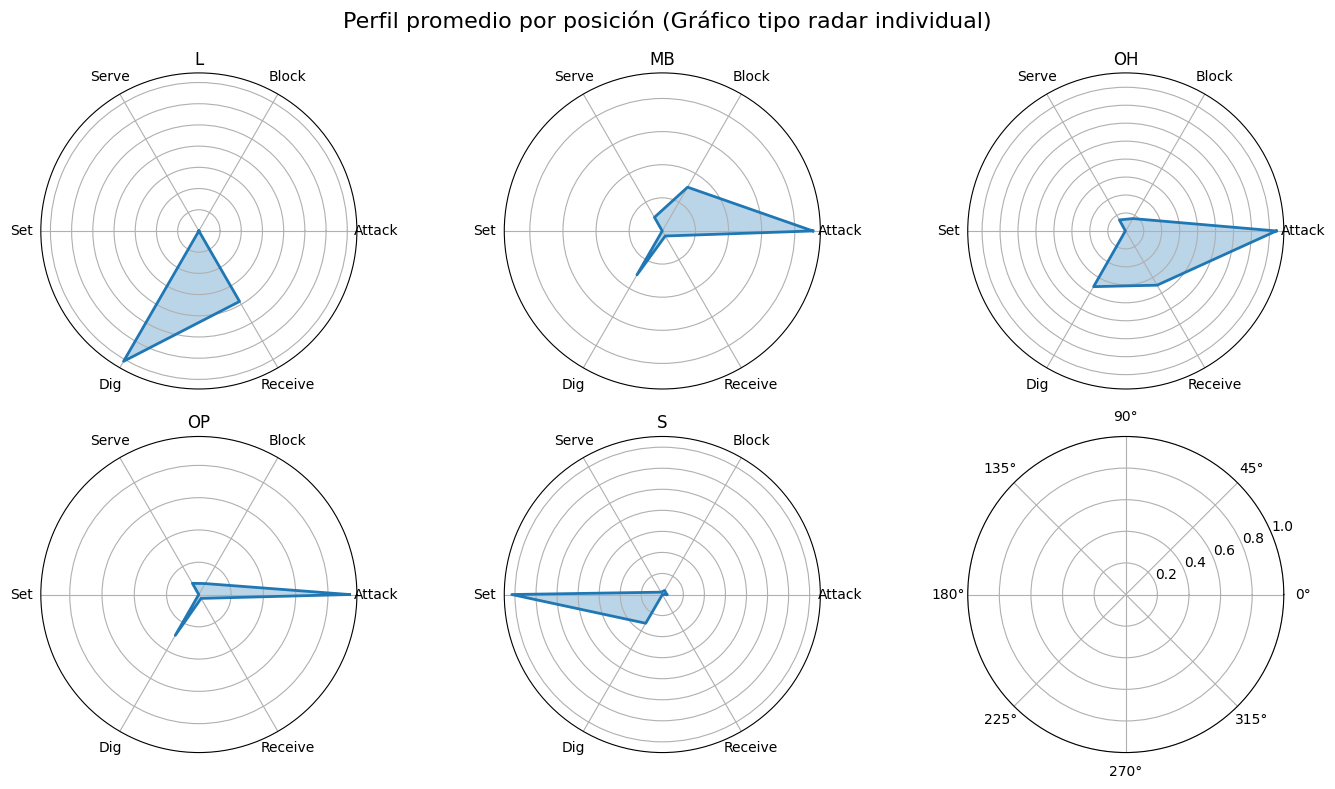

In [19]:
# Cálculo de medias por posición
media_estadisticas_por_posicion = data_frame.groupby('Position')[['Attack', 'Block', 'Serve', 'Set', 'Dig', 'Receive']].mean()

# Reorganizar para formato largo
estadisticas_largas = media_estadisticas_por_posicion.reset_index().melt(id_vars='Position', 
    var_name='Estadística', value_name='Promedio')

plt.figure(figsize=(10, 6))
sns.barplot(data=estadisticas_largas, x='Estadística', y='Promedio', hue='Position')

plt.title('Promedio de estadísticas individuales por posición')
plt.ylabel('Valor promedio')
plt.xlabel('Estadística')
plt.legend(title='Posición')
plt.tight_layout()
plt.show()


# Datos
categorias = media_estadisticas_por_posicion.columns.tolist()
labels = np.array(categorias)
n = len(labels)

# Subgráficos por posición
fig, axs = plt.subplots(2, 3, subplot_kw=dict(polar=True), figsize=(14, 8))
axs = axs.flatten()

for i, pos in enumerate(media_estadisticas_por_posicion.index):
    valores = media_estadisticas_por_posicion.loc[pos].values.flatten().tolist()
    valores += valores[:1]  # cerrar el círculo
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False).tolist()
    angles += angles[:1]

    axs[i].plot(angles, valores, linewidth=2)
    axs[i].fill(angles, valores, alpha=0.3)
    axs[i].set_title(pos)
    axs[i].set_xticks(angles[:-1])
    axs[i].set_xticklabels(labels)
    axs[i].set_yticklabels([])

fig.suptitle('Perfil promedio por posición (Gráfico tipo radar individual)', fontsize=16)
plt.tight_layout()
plt.show()

